In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.tensorboard import *

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
import datetime
import pandas as pd
import numpy as np

In [5]:
path = Path('../data/train')

In [6]:
path.ls()

(#3) [Path('../data/train/healthy_wheat'),Path('../data/train/leaf_rust'),Path('../data/train/stem_rust')]

In [7]:
def sort_image_by_dimensions(path, size):
    w, h = Image.open(path).size
    return w >= size and h >= size

In [8]:
image_size = 460

In [9]:
cbs = TensorBoardCallback(projector=True)

In [10]:
def correct_sized_images(path):
    return [img for img in get_image_files(path) if sort_image_by_dimensions(img, image_size)]

In [11]:
def get_y(r): return parent_label(r).split(" ")

In [12]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                        splitter=RandomSplitter(seed=42),
                        get_items=correct_sized_images,
                        get_y=get_y,
                        item_tfms=Resize(image_size),
                        batch_tfms=aug_transforms(size=size, min_scale=0.75))

    return dblock.dataloaders(path, bs=bs, num_workers=0)

In [13]:
batch_size = 64
dls = get_dls(batch_size, 64)

In [14]:
# dls.show_batch(max_n=4, nrows=1)

In [15]:
# man_in = tensor([[-3.4, 1.8, -3.4],
#                  [0.6104, -1.1992, -2.6289]], dtype=torch.double)
#
# man_targ = tensor([[0, 1, 0],
#                    [0, 1, 0]], dtype=torch.double)

In [16]:
# x,y = dls.train.one_batch()

In [17]:
cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')

In [37]:
from torch.nn.modules import loss

from fastai.losses import *

class smooth_binary_cross_entropy(loss._Loss):

    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean',
             pos_weight: Optional[Tensor] = None) -> None:
        super(smooth_binary_cross_entropy, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
    # def __init__(self,
    #              pos_weight: Optional[Tensor] = None,
    #              reduction: str = 'mean',
    #              thresh=0.5) -> None:
    #     store_attr()
    #
    #     self.pos_weight = pos_weight
    #     self.reduction = reduction
    #     self.thresh = thresh

    # pos_weight = torch.ones(3, device=cuda0)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        c = target.shape[1]
        eps = 0.1
        smoothed_target = torch.where(target==1, 1-(eps+(eps/c)), eps/c)
        return F.binary_cross_entropy_with_logits(input,
                                                  smoothed_target,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

    # def activation(self, x): return torch.sigmoid(x)

@delegates()
class smooth_loss_v2(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(smooth_binary_cross_entropy, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

    # device = inputs.device
    #
    # c = targets.shape[1]
    # eps = 0.1
    # threshold = 0.5



    # inputs_sig = inputs.sigmoid()
    
    # print(f"inputs_sig:\n{inputs_sig}\n")



    # smoothed_targets = torch.where(targets==1, 1-(eps+(eps/c)), eps/c)
    #
    # pos_weight = torch.ones(3, device=device)
    #
    # tst = BCEWithLogitsLossFlat(pos_weight=pos_weight)
    # loss = tst(inputs, smoothed_targets)



    # smoothed_targets_two = targets * (1.0 - eps) + 0.5 * eps
    
    # loss = activs/smoothed_targets
    
    # print(f"smoothed_targets:\n{smoothed_targets}\n")
    # print(f"targets:\n{targets}\n")
    # print(f"divided:\n{(inputs_sig/smoothed_targets)}\n")

    # pred = torch.sigmoid(inputs)
    # bce_loss_yang_zhang = -(pred.log()*smoothed_targets + (1-smoothed_targets)*(1-pred).log()).mean()
    # return bce_loss_yang_zhang
    # print(bce_loss_yang_zhang)
    
#     bce_loss = -torch.where(targets==1, inputs_sig, 1-inputs_sig).log().mean()
#     loss = -torch.where(targets==1, (inputs_sig/smoothed_targets), (inputs_sig/smoothed_targets)).log()
#     loss = -(inputs_sig/smoothed_targets).log()
    
#     print(f"bce_loss: {bce_loss}")
#     print(f"bce_loss_smoothed: {bce_loss_smoothed}")
#     print(f"bce_res: {bce_res}")
    
    # return F.binary_cross_entropy_with_logits(inputs, smoothed_targets)
#     return F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#     return loss
#     return loss*(eps/c)+(1-eps)

In [19]:
# smooth_binary_cross_entropy(man_in, man_targ)

In [42]:
pos_weight = torch.ones(3, device=cuda0)
# tst = BCEWithLogitsLossFlat(pos_weight=pos_weight, reduction='none')
# tst(man_in, man_targ)

In [21]:
# F.binary_cross_entropy_with_logits??

In [45]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls,
                    resnet50,
                    metrics=partial(accuracy_multi, thresh=0.2),
                    loss_func=smooth_loss_v2(pos_weight=pos_weight))

In [23]:
# print(x.shape)
# activs = learn.model(x)
# activs.shape

In [24]:
# activs[0],y[0]

In [25]:
# loss_func = nn.BCEWithLogitsLoss(reduction='none')
# loss = loss_func(activs,y)
# loss

In [26]:
# smooth_binary_cross_entropy(activs[0],y[0])

In [27]:
# preds,_ = learn.get_preds(dl=[(x,y)])
# print(preds[0],preds[0].sum())
# print(y[0])

In [28]:
# print(F.binary_cross_entropy_with_logits(preds, y))

In [29]:
# smooth_binary_cross_entropy(preds, y)

In [30]:
# F.binary_cross_entropy_with_logits??

In [31]:
#learn.lr_find()

In [32]:
# with learn.no_bar():
#     learn.fine_tune(1, freeze_epochs=0)

In [46]:
with learn.no_bar():
    learn.fine_tune(10, freeze_epochs=3)

[0, 0.9599149823188782, 0.7530781626701355, 0.3641975522041321, '01:20']
[1, 0.9326222538948059, 0.7398741245269775, 0.46296295523643494, '01:20']
[2, 0.9154893159866333, 0.739974856376648, 0.5771605372428894, '01:20']
[0, 0.7882170081138611, 0.7008023262023926, 0.5524691343307495, '01:21']
[1, 0.7367362976074219, 0.6399116516113281, 0.5771605372428894, '01:19']
[2, 0.7228783369064331, 0.6352909207344055, 0.6172839999198914, '01:21']
[3, 0.7082855105400085, 0.598501980304718, 0.6358025074005127, '01:21']
[4, 0.6930506825447083, 0.597619891166687, 0.6234568357467651, '01:20']
[5, 0.6688598990440369, 0.7240462303161621, 0.6234568357467651, '01:20']
[6, 0.6409136652946472, 0.6546778082847595, 0.6296296119689941, '01:20']
[7, 0.6221668124198914, 0.6046907901763916, 0.6358025074005127, '01:19']
[8, 0.6020547747612, 0.5802660584449768, 0.654321014881134, '01:20']
[9, 0.5853248238563538, 0.5712122321128845, 0.6635802984237671, '01:20']


In [ ]:
learn.dls = get_dls(batch_size, 128)

In [ ]:
with learn.no_bar():
    learn.fine_tune(10)

In [ ]:
learn.dls = get_dls(batch_size, 256)

In [ ]:
with learn.no_bar():
    learn.fine_tune(40)

In [47]:
learn.loss_func

FlattenedLoss of smooth_binary_cross_entropy()

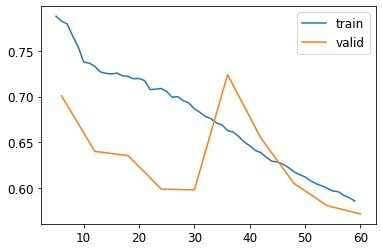

In [48]:
learn.recorder.plot_loss()

In [49]:
x,y = dls.one_batch()

In [50]:
import random as rnd

preds,t = learn.get_preds(dl=[(x,y)])
rand_idx = rnd.randint(0, len(preds))-1
print(preds[rand_idx], t[rand_idx])

tensor([0.0707, 0.8691, 0.2792]) TensorMultiCategory([0., 1., 0.])


In [51]:
preds[0].sum()

tensor(1.1680)

In [52]:
learn.model(x).shape

torch.Size([64, 3])

In [55]:
model_name = "resnet50"
time_now = datetime.datetime.now().strftime(format='%H%M%S')

export_path = Path('../models/exported')

model_filename = export_path/f"{time_now}_{model_name}_B{batch_size}S{image_size}.pkl"
learn.export(fname=model_filename)

In [ ]:
learn.dls.vocab